## Sentiment analysis Using linear regression
1. Download and import dataset
2. Clean, rename columns, check data
3. Tokenize words
4. Train model
5. Check accuracy
6. Run AUC, F1
 
 
**Extras**
- Build Binary classifier (positive/negative)
- Interpet results
- Print words with the most positive and negative weights

In [45]:
!wget -nc https://lazyprogrammer.me/course_files/AirlineTweets.csv

File 'AirlineTweets.csv' already there; not retrieving.



In [1]:
# import libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import f1_score, roc_auc_score, roc_curve, auc, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [2]:
threshold = 0.5 # confidence in sentiment threshold 

def process_string(s):
    # Split the string on spaces
    words = s.split()
    
    # Remove first element
    words.pop(0)
    
    # Rejoin the list into a string
    return ' '.join(words)


df = pd.read_csv('AirlineTweets.csv',delimiter=",")
df = df[df['airline_sentiment_confidence']>threshold]
df = df[['airline_sentiment','text']]

# Apply the function to each row in the DataFrame
df['text'] = df['text'].apply(process_string)

sentiment = df["airline_sentiment"]
text = df["text"]

# Display the first few rows of the DataFrame
print(df.head())
print(f"Number of samples: {len(df)}")

## Convert classes to numbers
#target_map = {"pos":1,"neg":0,"neut":2}
#df['airline_sentiment'] = df['airline_sentiment'].map(target_map)


  airline_sentiment                                               text
0           neutral                               What @dhepburn said.
2           neutral  I didn't today... Must mean I need to take ano...
3          negative  it's really aggressive to blast obnoxious "ent...
4          negative           and it's a really big bad thing about it
5          negative  seriously would pay $30 a flight for seats tha...
Number of samples: 14404


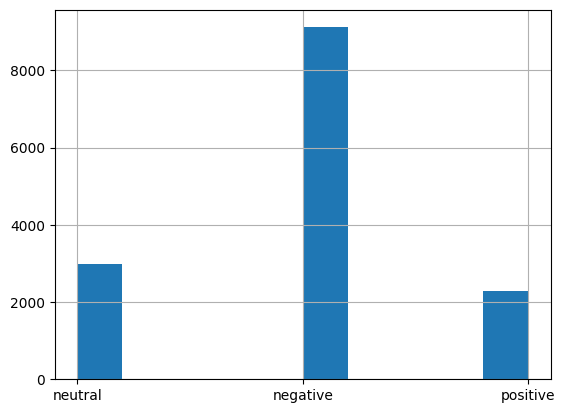

In [3]:
#TODO: create a function that splits the data but keeps the same percentage of each class in both train and test
# Check for class imbalance

test_plots = df['airline_sentiment'].hist()

In [4]:
X_train, X_test, y_train, y_test = train_test_split(text, sentiment, test_size=0.3, random_state=42)


tfidf_vectorizer = TfidfVectorizer(lowercase=True)
count_vectorizer = CountVectorizer()

# function .fit_transform() trains on a new vocabulary, 
# while .transform() trains on existing vocabulary
X_train_vect = tfidf_vectorizer.fit_transform(X_train)
X_test_vect = tfidf_vectorizer.transform(X_test)


In [6]:
# Train a logistic regression model
model = LogisticRegression(max_iter=1000,class_weight='balanced')
model.fit(X_train_vect, y_train)
print("Model train acc:",model.score(X_train_vect,y_train))
print("Model test acc:",model.score(X_test_vect,y_test))

Model train acc: 0.8876215036699068
Model test acc: 0.7903748264692272


In [7]:
preds = model.predict_proba(X_test_vect)
probs = ["negative","neuteral","positive"]

negative_sentiment = {}
neuteral_sentiment = {}
positive_sentiment = {}


for i,pred in enumerate(preds):
  
    index = np.argmax(pred)
    
    if index == 0:
        negative_sentiment[X_test.iloc[i]] = pred[index]
    
    if index == 1:
        neuteral_sentiment[X_test.iloc[i]] = pred[index]
    
    if index == 2:
        positive_sentiment[X_test.iloc[i]] = pred[index]
    
        
print(f"pos: {len(positive_sentiment)} ,\n neg: {len(negative_sentiment)}, neut: {len(neuteral_sentiment)}")

pos: 683 ,
 neg: 2523, neut: 1076


In [8]:
# get most positive review
max_key = max(positive_sentiment, key=positive_sentiment.get)
print(max_key)
print(positive_sentiment[max_key])


# get most negative review
max_key = max(negative_sentiment, key=negative_sentiment.get)
print(max_key)
print(negative_sentiment[max_key])



Great - thank you.
0.9997177575686934
I've been on hold ANOTHER hour and still nothing. My Cancelled Flighted flight was supposed to be six hours from now. #Stranded
0.9986227816676736


In [9]:
# Sample custom text for prediction
custom_text = ["it sucked so bad", "it was awesome"]

# Transform the custom text using the same vectorizer
custom_text_vectorized = tfidf_vectorizer.transform(custom_text)

# Make the prediction
predictions = model.predict(custom_text_vectorized)

# Display the predictions
for text, prediction in zip(custom_text, predictions):
    print(f"Text: {text}\nPrediction: {prediction}\n")

Text: it sucked so bad
Prediction: neutral

Text: it was awesome
Prediction: positive



In [10]:
#Calculate AUC Score
P_train = model.predict_proba(X_train_vect)
P_test = model.predict_proba(X_test_vect)
print("Train AUC:",roc_auc_score(y_train,P_train,multi_class='ovo'))
print("Test AUC:",roc_auc_score(y_test,P_test,multi_class='ovo'))


Train AUC: 0.9737538638876604
Test AUC: 0.9083794410170761


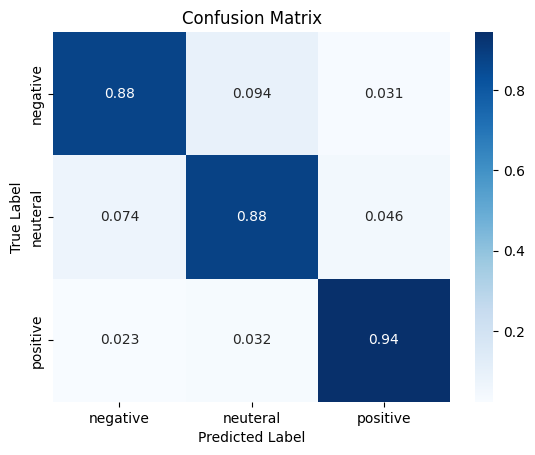

In [11]:
# confusion matrix
P_train = model.predict(X_train_vect)
P_test = model.predict(X_test_vect)
cm = confusion_matrix(y_train,P_train,normalize='true')

sns.heatmap(cm, annot=True, cmap='Blues', xticklabels=probs, yticklabels=probs)

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

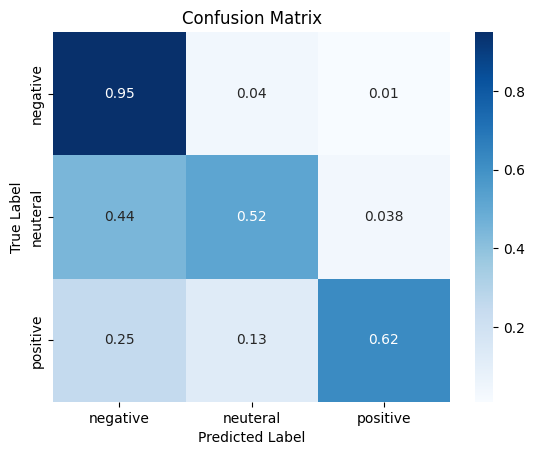

In [46]:
cm = confusion_matrix(y_test,P_test,normalize='true')

sns.heatmap(cm, annot=True, cmap='Blues', xticklabels=probs, yticklabels=probs)

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


In [65]:
binary_list =  df[df['airline_sentiment'] != "neutral"]

text = binary_list['text']
sentiment = binary_list['airline_sentiment']

X_train, X_test, y_train, y_test = train_test_split(text, sentiment, test_size=0.3, random_state=42)


tfidf_vectorizer = TfidfVectorizer(lowercase=True,max_features=2000)

# function .fit_transform() trains on a new vocabulary, 
# while .transform() trains on existing vocabulary
X_train_vect = tfidf_vectorizer.fit_transform(X_train)
X_test_vect = tfidf_vectorizer.transform(X_test)


model = LogisticRegression(max_iter=1000)
model.fit(X_train_vect, y_train)
print("Model train acc:",model.score(X_train_vect,y_train))
print("Model test acc:",model.score(X_test_vect,y_test))

Model train acc: 0.9263527054108216
Model test acc: 0.9138182880514168


In [70]:
#Calculate AUC Score
P_train = model.predict_proba(X_train_vect)[:,1]
P_test = model.predict_proba(X_test_vect)[:,1]
print("Train AUC:",roc_auc_score(y_train,P_train))
print("Test AUC:",roc_auc_score(y_test,P_test))


Train AUC: 0.9783714405015876
Test AUC: 0.9571362719347936


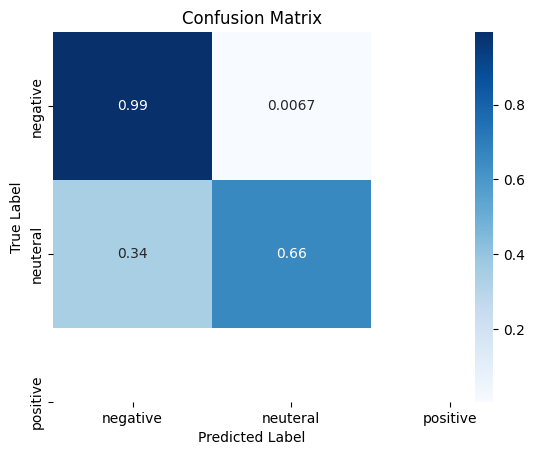

In [66]:
# confusion matrix
P_train = model.predict(X_train_vect)
P_test = model.predict(X_test_vect)
cm = confusion_matrix(y_train,P_train,normalize='true')

sns.heatmap(cm, annot=True, cmap='Blues', xticklabels=probs, yticklabels=probs)

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

(array([  2.,   1.,   2.,   2.,   5.,  10.,  30.,  70., 215., 809., 490.,
        205.,  94.,  35.,  14.,   5.,   2.,   2.,   0.,   2.,   1.,   1.,
          1.,   0.,   0.,   0.,   0.,   0.,   0.,   2.]),
 array([-4.06449039, -3.66555875, -3.2666271 , -2.86769546, -2.46876381,
        -2.06983217, -1.67090052, -1.27196888, -0.87303723, -0.47410559,
        -0.07517394,  0.3237577 ,  0.72268935,  1.12162099,  1.52055264,
         1.91948428,  2.31841593,  2.71734757,  3.11627922,  3.51521086,
         3.91414251,  4.31307415,  4.7120058 ,  5.11093744,  5.50986909,
         5.90880073,  6.30773237,  6.70666402,  7.10559566,  7.50452731,
         7.90345895]),
 <BarContainer object of 30 artists>)

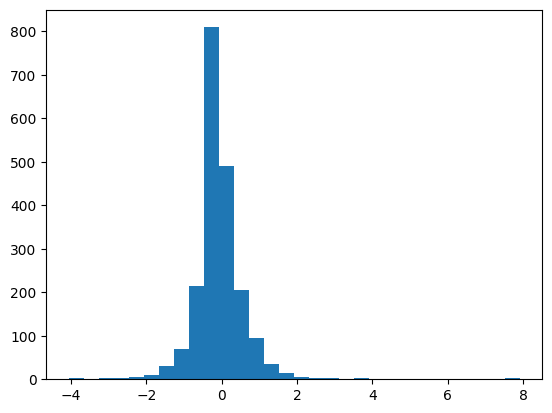

In [71]:
# model.coef to obtain the wights
plt.hist(model.coef_[0],bins=30)


In [74]:
# word to index dictionary
word_index_map = tfidf_vectorizer.vocabulary_
word_index_map

{'jetblue': 967,
 'the': 1730,
 'last': 1003,
 'email': 592,
 'response': 1473,
 'we': 1908,
 'this': 1742,
 'best': 247,
 'you': 1992,
 'but': 294,
 'hope': 877,
 'back': 220,
 'future': 770,
 'nice': 1191,
 'touch': 1779,
 'lol': 1052,
 'changed': 343,
 'planes': 1327,
 'hate': 832,
 'seating': 1535,
 'over': 1264,
 'if': 911,
 'wanted': 1895,
 'would': 1969,
 'have': 834,
 'booked': 268,
 'it': 958,
 'will': 1938,
 'get': 778,
 'complaint': 403,
 'still': 1659,
 'waiting': 1891,
 'on': 1236,
 'she': 1565,
 'was': 1897,
 'phone': 1310,
 'agent': 110,
 'pls': 1338,
 'do': 553,
 'pleasant': 1335,
 'and': 148,
 'delivered': 500,
 'yes': 1987,
 'very': 1879,
 'much': 1168,
 'so': 1610,
 'looking': 1058,
 'forward': 743,
 'to': 1767,
 'using': 1871,
 'your': 1994,
 'airlines': 121,
 'for': 738,
 'flights': 722,
 'never': 1185,
 'again': 109,
 'baggage': 226,
 'drop': 573,
 'at': 197,
 'phl': 1307,
 'is': 952,
 'incredibly': 931,
 'up': 1854,
 'unacceptable': 1830,
 'service': 1555,
 'flig

In [76]:
# check the weghts of each words
threshold = 2
print("most positive words")

for word, index in word_index_map.items():
    weight = model.coef_[0][index]
    if weight > threshold:
        print(word,weight)

most positive words
best 3.693244867280088
thanks 7.903458953990085
great 5.101586465726998
thank 7.639586897778733
appreciate 2.3979403918963897
love 4.509681308438933
good 3.0300527976557383
well 2.309902973358702
worries 2.1020122229363727
amazing 3.9632860704794797
awesome 3.783926925628026
excellent 2.3835348784293346
thx 2.913762788547524
kudos 2.2474101897173484


In [78]:
# check the weghts of each words
threshold = 2
print("most positive words")

for word, index in word_index_map.items():
    weight = model.coef_[0][index]
    if weight < -threshold:
        print(word,weight)

most positive words
cancelled -3.0789635644418505
hours -3.2686955711590335
what -2.122549068187646
not -4.064490390404056
no -3.976160878470498
why -2.211479259666688
worst -3.077426696802334
delay -2.0209479804180086
hold -2.586557545578081
delayed -2.826639211006578
luggage -2.199374083694799
don -2.1187138798004503
nothing -2.0175062406238915
hour -2.3676553183089943


In [ ]:
# print the most wrong tweets for both classes
# find the most false positive with most confidence

# set class_weight = balanced